!pip install fredapi

!pip install yfinance

In [1]:
from fredapi import Fred
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
%%capture
fred = Fred(api_key = "ed1b2123fc23b6e2a2d8db120bb68b7b")

Variable Name:

Initial claim (ICSA) (Weekly) : A claim filed by an unemployed individual after a separation from an employer. The claim requests a determination of basic eligibility for the Unemployment Insurance program.

cpi (CPIAUCSL) (Monthly):

term_srpead (T10Y3M) (Daily): 10-Year Treasury Yield minus 3-Month Treasury Yield

dgs10 (DGS10) (Daily): 10-Year Treasury Constant Maturity Rate

credit_spred (BAA10YM) (Monthly): Corporate Bond Yield minus 10-Year Treasury Yield 

sp500 (^GDPC) (Daily):

SGIXSENT (Daily): Sentiment Index

VIX :

VIX_retrun :


In [3]:
%%capture
## Retrieve key U.S. macroeconomic and financial indicators from FRED. Dates = 2018-01-01 to 2025-10-30
series_ids = {
    "initial_claims": "ICSA",
    "cpi": "CPIAUCSL",
    "term_spread": "T10Y3M",
    "dgs10": "DGS10",
    "credit_spread": "BAA10YM",
} 
data = {}
for name, sid in series_ids.items():
    s = fred.get_series(sid)
    s.name = name 
    data[name] = fred.get_series(sid)
    
df = pd.DataFrame(data)
df = df[(df.index >= "2018-01-01") & (df.index <= "2025-10-30")]
full_index = pd.date_range(start="2018-01-01", end="2025-10-30", freq="D")
df = df.reindex(full_index)

sp500 = yf.download("^GSPC", start="2018-01-01", end="2025-10-30")
sp500 = sp500["Close"]
sp500.name = "sp500"

df_sent = pd.read_excel("C:\\Users\\User\\OneDrive\\Desktop\\SGIXSENT_INDEX_20040115-20252030.xlsx",
                   sheet_name=["20140115_20240115", "20240115_20251030"])
df1 = df_sent["20140115_20240115"]
df2 = df_sent["20240115_20251030"]
def clean_sentiment(df):
    df = df.iloc[1:, 1:3].copy()
    df.columns = ["SGIXSENT", "Date"]
    df["Date"] = pd.to_datetime(df["Date"])
    df["SGIXSENT"] = pd.to_numeric(df["SGIXSENT"], errors="coerce")
    df.set_index("Date", inplace=True)
    return df

df_sent1 = clean_sentiment(df_sent["20140115_20240115"])
df_sent2 = clean_sentiment(df_sent["20240115_20251030"])
df_sent = pd.concat([df_sent1, df_sent2]).sort_index()

df_sent = df_sent.loc["2018-01-01" : "2025-10-30"]
print(df_sent.head())
print(df_sent.tail())

vix = fred.get_series(
    "VIXCLS",
    observation_start="2018-01-01",
    observation_end="2025-10-30"
)
df_vix = pd.DataFrame(vix, columns=["VIX"])
df_vix.index = pd.to_datetime(df_vix.index)

dif_vix = df_vix.sort_index()
print(df_vix.isna().sum())

missing_dates =  df_vix[df_vix["VIX"].isna()].index
print(missing_dates)

In [4]:
df_vix = df_vix.dropna(subset=["VIX"])
df_vix["VIX_return"] = np.log(df_vix["VIX"] / df_vix["VIX"].shift(1))

In [5]:
%%capture
dif_vix = df_vix.sort_index()
print(df_vix.isna().sum())

df_vix.index = pd.to_datetime(df_vix.index)
df_sent.index = pd.to_datetime(df_sent.index)
sp500.index = pd.to_datetime(sp500.index)
df.index = pd.to_datetime(df.index)

In [6]:
%%capture
merged = pd.concat([df_vix, df_sent, sp500, df], axis=1, join="outer")
merged = merged.sort_index()
merged = merged.loc["2018-01-01" : "2025-10-30"]

cols_ffill_others = ["SGIXSENT", "cpi", "credit_spread", "term_spread", "dgs10"]
merged_full = merged.copy()
merged_full[cols_ffill_others] = merged_full[cols_ffill_others].ffill()
cutoff = pd.Timestamp("2025-09-22")
s = merged["initial_claims"]
s_b = s.bfill()
s_f = s.ffill()
initial_new = s.copy()
mask_before = initial_new.index < cutoff
initial_new.loc[mask_before] = s_b.loc[mask_before]
mask_after = initial_new.index >= cutoff
initial_new.loc[mask_after] = s_f.loc[mask_after]
merged_full["initial_claims"] = initial_new
merged_trading = merged_full[merged_full["^GSPC"].notna()].copy()
check_cpi = merged_trading["cpi"].notna().astype(int).resample("ME").sum()

merged_trading.isna().any().any()
merged_trading.isna().sum()

merged_trading["VIX_return"] = merged_trading["VIX_return"]

merged_trading.to_csv("merged_trading.csv", index=True)

I applied **front-fill** for `"SGIXSENT"`, `"cpi"`, and `"credit_spread"`.  

For `"Initial_Claims"`, I used **back-fill** before *2025-09-22*, since the data is published every Saturday (this is the most recent release available from FRED).  
After *2025-09-22*, I switched to **front-fill** for `"Initial_Claims"`.  

In addition, `"VIX_return"`  had no value on *2018-01-02* due to the calculation method, so I assigned it a value of **0** in the CSV file.

Also, I removed daily observations where the **U.S. stock market was closed**, keeping only the dates when the S&P 500 (`^GSPC`) had available data.

2025-10-13 (Columbus Day) :The stock market remains open, but the bond market is closed. So I frontfill **term_spread**, **dgs10** for this day.

In [7]:
%%capture
merged_trading.index.to_series().diff().value_counts()
1538 + 355 +53 + 21 # Confirm trading Days
print(merged_trading.describe().T)

## 1.1 Exploratory Data Analysis

In [8]:
merged_trading = merged_trading.copy()

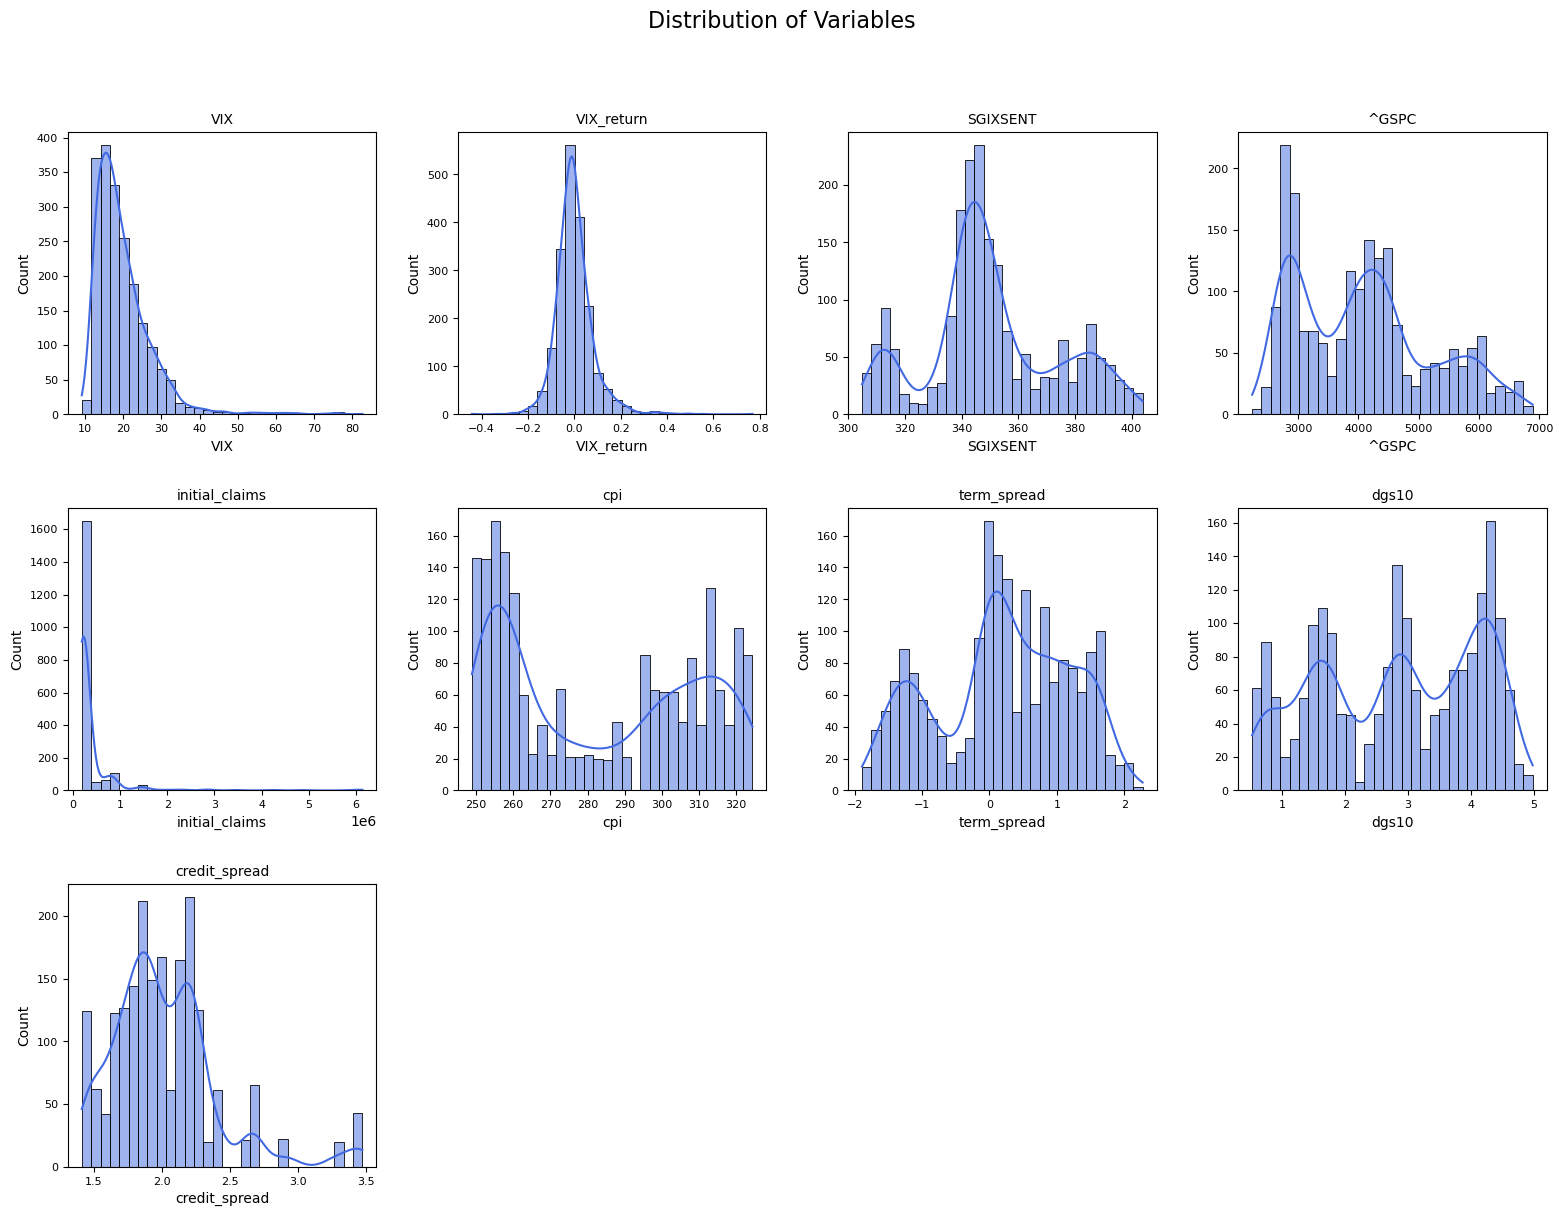

In [9]:
# Distribution of Vairables
import seaborn as sns
import matplotlib.pyplot as plt
cols = 4
variables = merged_trading.columns
n = len(variables)
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(variables):
    sns.histplot(merged_trading[col], kde=True, ax=axes[i], bins=30, color='royalblue')
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Variables", fontsize=16, y=1.02)
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.5)
plt.show()

#VIX（波動指數）水準呈現明顯右偏分佈，顯示高波動日較低波動日更為罕見。
#VIX return（報酬）顯示典型的厚尾與尖峰（leptokurtic）特性，反映金融市場常見的極端波動事件。
#SGIXSENT、term_spread、dgs10 等宏觀變數呈現多峰（multi-modal）分佈，暗示市場存在不同的結構性 regime（例如寬鬆 vs. 緊縮、低波動 vs. 高波動）。
#Initial claims 與 credit spread 變數具有極端偏態與離群值，可能需要進行 log transform、標準化或離群值處理。

VIX（波動指數）水準呈現明顯右偏分佈，顯示高波動日較低波動日更為罕見。

VIX return（報酬）顯示典型的厚尾與尖峰（leptokurtic）特性，反映金融市場常見的極端波動事件。

SGIXSENT、term_spread、dgs10 等宏觀變數呈現多峰（multi-modal）分佈，暗示市場存在不同的結構性 regime（例如寬鬆 vs. 緊縮、低波動 vs. 高波動）。

CPI（消費者物價指數）分佈呈現右偏與多峰特徵，顯示物價水準在不同年份可能存在結構性變動（如 COVID 期間通膨急升），反映出宏觀經濟 regime 的切換。

^GSPC（S&P 500 指數）呈現多峰且分散的分佈，代表股市水平在不同市場階段（牛市、熊市、疫情期間）之間有明顯差異，顯示長期趨勢與 regime switching 的存在。

Initial claims 與 credit spread 變數具有極端偏態與離群值，可能需要進行 log transform、標準化或離群值處理。

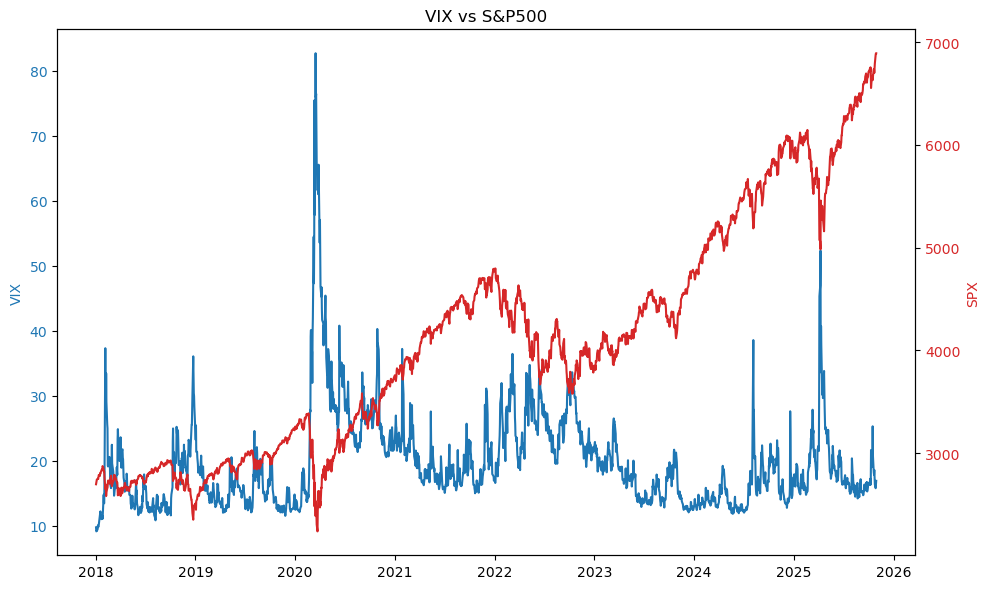

In [11]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot( merged_trading.index, merged_trading["VIX"], color="tab:blue", label="VIX")
ax1.set_ylabel("VIX", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot( merged_trading.index, merged_trading["^GSPC"], color="tab:red", label="SPX (^GSPC)")
ax2.set_ylabel("SPX", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.title("VIX vs S&P500")
fig.tight_layout()
plt.show()

# VIX spikes are strongly associated with sharp declines in the S&P500.

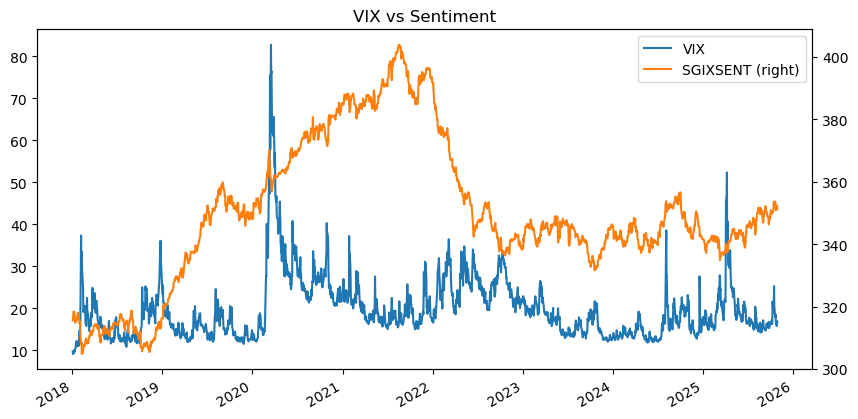

In [12]:
merged_trading[["VIX", "SGIXSENT"]].plot(secondary_y="SGIXSENT", figsize=(10, 5))
plt.title("VIX vs Sentiment")
plt.show()

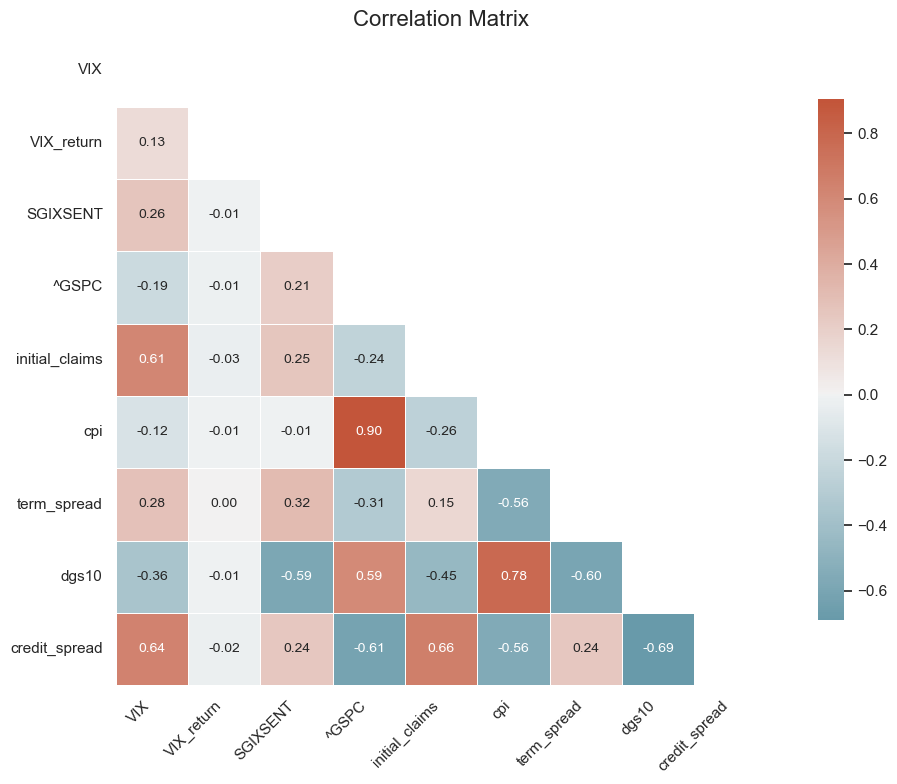

In [17]:
# correlation Heatmap 
corr = merged_trading.corr()
plt.figure(figsize=(11, 8))
sns.set_theme(style="white")

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    center=0,
    square=True,
    linewidth=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

整體相關性結果顯示：VIX 與信用風險、失業與情緒指標具明顯正向關係；與股市則呈典型負相關。

但對 VIX return 而言，所有變數的線性相關性接近 0，意味著 機器學習模型必須依賴非線性特徵與 GARCH 殘差的時序結構 才能取得預測力。

In [18]:
from statsmodels.graphics.gofplots import qqplot

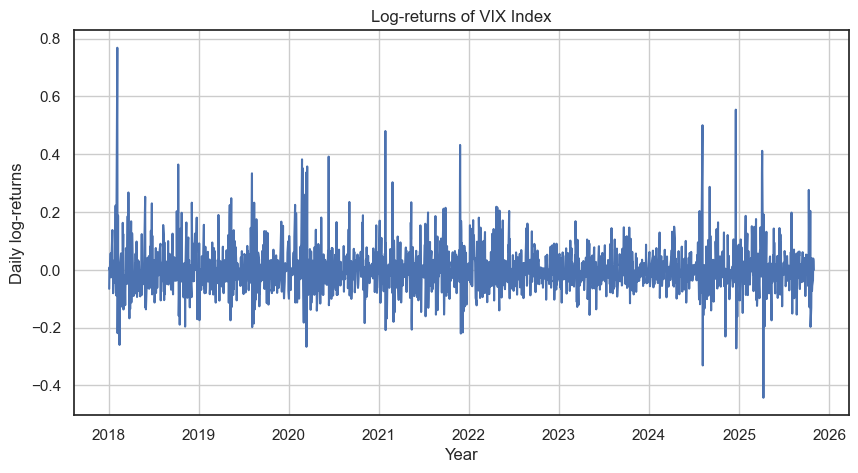

In [19]:
## 畫 vix index 的 log return aka VIX_return
plt.figure(figsize=(10, 5))
plt.plot(df_vix.index, df_vix["VIX_return"], color = "b")
plt.title("Log-returns of VIX Index")
plt.xlabel("Year")
plt.ylabel("Daily log-returns")
plt.grid(True)
plt.show()  #VIX log-return 序列符合金融時間序列常見的特性：均值為零、波動聚集、方差非恆定。 -> 支持後續使用 GARCH 或 ARCH 類模型。

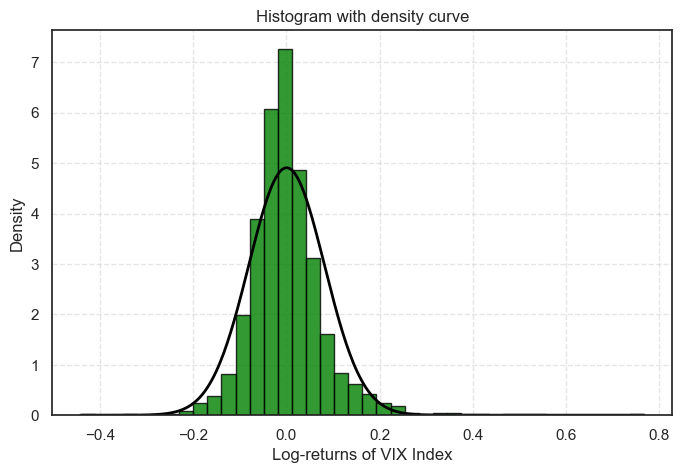

In [20]:
# Histogram of  VIX_return
from scipy.stats import norm
mu, sigma = df_vix["VIX_return"].mean(), df_vix["VIX_return"].std()
plt.figure(figsize=(8, 5))
plt.hist(df_vix["VIX_return"], bins=40, density=True, color='green', alpha=0.8, edgecolor='black')
x = np.linspace(df_vix["VIX_return"].min(), df_vix["VIX_return"].max(), 500)
plt.plot(x, norm.pdf(x, mu, sigma), color='black', linewidth=2)
plt.title("Histogram with density curve")
plt.xlabel("Log-returns of VIX Index")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()   #VIX log-return 的分布非正態、具 leptokurtic (高峰厚尾) 特性 -> 常態假設下的風險評估會低估極端波動發生的機率

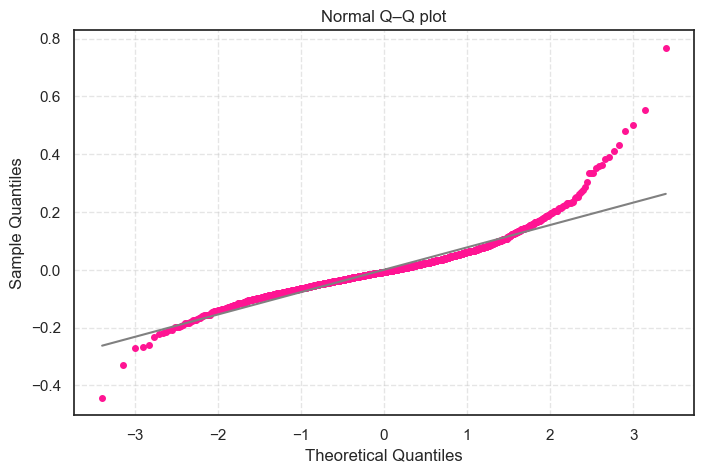

In [21]:
import scipy.stats as stats
data = df_vix["VIX_return"].dropna().values   

plt.figure(figsize=(8, 5))
res = stats.probplot(data, dist="norm", plot=plt)

plt.title("Normal Q–Q plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

plt.setp(plt.gca().lines[0], color="deeppink", marker="o", markersize=4, linestyle="")  
plt.setp(plt.gca().lines[1], color="gray", linewidth=1.5)                                

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()  
# VIX log-return 不服從常態分布，表現出 非對稱且厚尾的分布特性，常態假設（如OLS殘差獨立正態）不適用。應考慮 t-distribution GARCH 或 EGARCH、GJR-GARCH 模型。
# heavy tails, leptokurtosis, skewness

In [26]:
print(df_vix["VIX_return"].describe())
print(df_vix["VIX_return"].isna().sum())

count    1994.000000
mean        0.000275
std         0.081281
min        -0.442449
25%        -0.044401
50%        -0.007325
75%         0.034580
max         0.768245
Name: VIX_return, dtype: float64
1


1. 平均報酬（mean ≈ 0）接近零

2. std 偏大 -> 波動率大

3. max 遠大於 min -> 右偏 -> 快速飆升但下跌較慢

4. 50 % < 0 -> 大多數時間VIX是下跌的 -> 市場平穩或者樂觀 -> 恐慌事件少但影響大

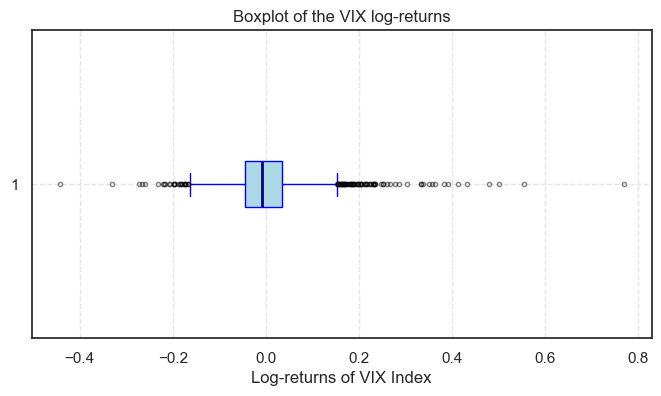

In [27]:
# Boxplot of the VIX_return
plt.figure(figsize=(8, 4))
plt.boxplot(data,
            vert=False,               
            patch_artist=True,         
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='darkblue', linewidth=2),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='.', color='purple', alpha=0.5))

plt.title("Boxplot of the VIX log-returns")
plt.xlabel("Log-returns of VIX Index")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()  #報酬分布呈現偏態與高峰度，可進一步用 Jarque–Bera test 或 Shapiro–Wilk test 驗證非常態性。

In [33]:
from scipy.stats import (jarque_bera, shapiro)

jb_stat, p_value = jarque_bera(data)

print("Jarque-Bera Statistic:", jb_stat)
print("p-value:", p_value)

stat, p = shapiro(df_vix["VIX_return"].dropna())

print(f"Shapiro-Wilk Statistic: {stat:.4f}")
print(f"p-value: {p:.4e}")

# vix_return is right-skewness, strong leptokurtosis, and frequent extreme jumps

Jarque-Bera Statistic: 7271.848086393983
p-value: 0.0
Shapiro-Wilk Statistic: 0.9073
p-value: 3.3161e-33


In [ ]:
%%capture
##把前面四張圖表合併成一份，跟前面一模一樣，所以我就先把它隱藏了。
from scipy.stats import norm, probplot
data = df_vix["VIX_return"].dropna()

plt.figure(figsize=(12, 8))

# (a) Time series
plt.subplot(2, 2, 1)
plt.plot(df_vix.index, df_vix["VIX_return"], color='blue', linewidth=0.8)
plt.title("(a) Log-returns of the VIX index")
plt.xlabel("Year")
plt.ylabel("Daily log-returns")
plt.grid(True, linestyle='--', alpha=0.5)

# (b) Histogram + density
plt.subplot(2, 2, 2)
mu, sigma = data.mean(), data.std()
x = np.linspace(data.min(), data.max(), 500)
plt.hist(data, bins=40, density=True, color='green', alpha=0.8, edgecolor='black')
plt.plot(x, norm.pdf(x, mu, sigma), color='black', linewidth=2)
plt.title("(b) Histogram with density curve")
plt.xlabel("Log-returns")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)

# (c) Q–Q Plot
plt.subplot(2, 2, 3)
probplot(data, dist="norm", plot=plt)
plt.title("(c) Normal Q–Q plot")
plt.grid(True, linestyle='--', alpha=0.5)

# (d) Boxplot
plt.subplot(2, 2, 4)
plt.boxplot(data, vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='darkblue', linewidth=2),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='.', color='purple', alpha=0.5))
plt.title("(d) Boxplot of the VIX log-returns")
plt.xlabel("Log-returns")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
%%capture 
# Paper 有畫但我覺得沒必要所以我先隱藏了
# 假設要檢查 df_vix 或 merged_trading 
missing = df_vix.isna().mean()   # 每個欄位的缺失比例 (0~1)

plt.figure(figsize=(8, 4))
plt.scatter(missing.index, missing.values, color='red', s=50)
plt.axhline(0, color='gray', linewidth=0.8)
plt.title("Missing values by variables", fontweight='bold')
plt.xlabel("Variables")
plt.ylabel("Number of missing values")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

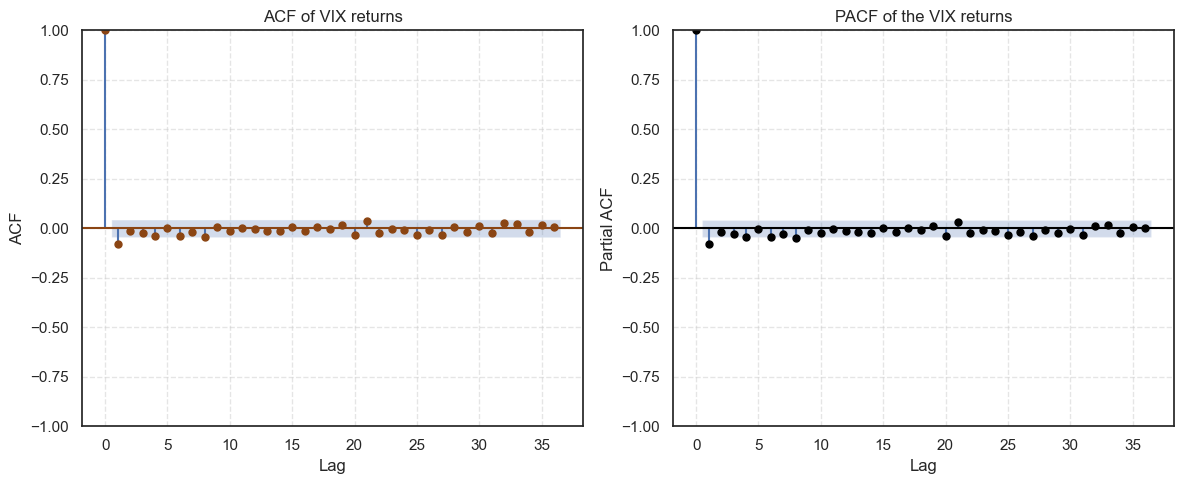

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(data, lags=36, ax=axes[0], color='saddlebrown')
axes[0].set_title("ACF of VIX returns")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")
axes[0].grid(True, linestyle='--', alpha=0.5)

plot_pacf(data, lags=36, ax=axes[1], color='black')
axes[1].set_title("PACF of the VIX returns")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial ACF")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# VIX log-returns 沒有顯著線性自相關。 from ACF
# = white noise but will have volatility clustering. from PACF

<Figure size 1000x500 with 0 Axes>

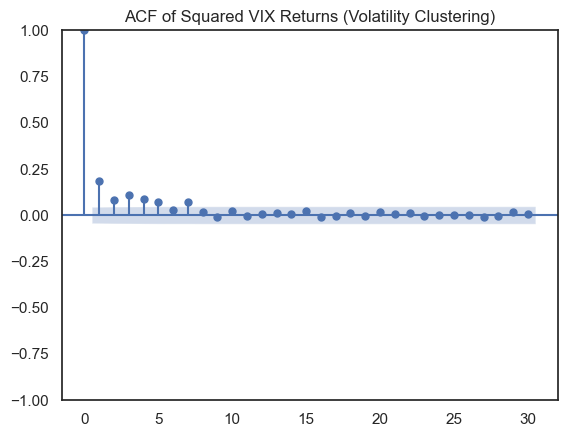

In [40]:
# The ACF of return ^2

sq_returns = data ** 2 # Squared returns

fig = plt.figure(figsize=(10, 5))
sm.graphics.tsa.plot_acf(sq_returns, lags=30)
plt.title("ACF of Squared VIX Returns (Volatility Clustering)") # Plot ACF for squared returns
plt.show()
# While the raw returns themselves behave like white noise, the squared returns exhibit clear persistence, 
# indicating strong volatility clustering in the VIX series.

<Figure size 1000x500 with 0 Axes>

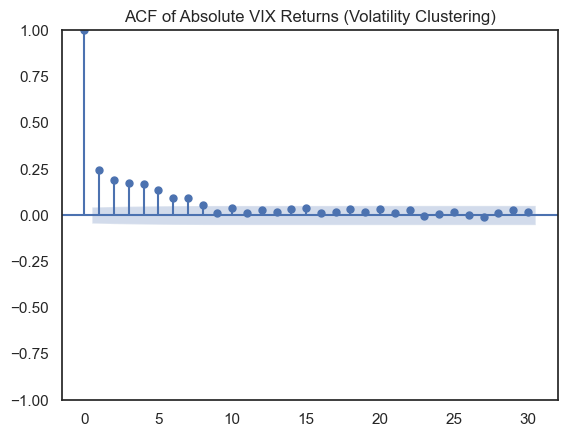

In [45]:
# Compute absolute returns
abs_returns = np.abs(data)

# Plot ACF for absolute returns
fig = plt.figure(figsize=(10, 5))
sm.graphics.tsa.plot_acf(abs_returns, lags=30)
plt.title("ACF of Absolute VIX Returns (Volatility Clustering)")
plt.show()

In [47]:
%%capture
## 把上面三張ACF 和在一起 一樣先隱藏
# --- Prepare series ---
returns = merged_trading["VIX_return"].dropna()
sq_returns = returns ** 2
abs_returns = returns.abs()

# --- Plot 3-panel ACF figure ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

### 1. Return ACF (should be ~ white noise)
sm.graphics.tsa.plot_acf(returns, lags=30, ax=axes[0])
axes[0].set_title("ACF of VIX Returns (White Noise Behavior)")

### 2. Squared Returns ACF (Volatility Clustering)
sm.graphics.tsa.plot_acf(sq_returns, lags=30, ax=axes[1])
axes[1].set_title("ACF of Squared VIX Returns (Volatility Clustering)")

### 3. Absolute Returns ACF (Volatility Clustering)
sm.graphics.tsa.plot_acf(abs_returns, lags=30, ax=axes[2])
axes[2].set_title("ACF of Absolute VIX Returns (Volatility Clustering)")

plt.tight_layout()
plt.show()

# 2. GARCH MODEL

In [63]:
import pandas as pd
import numpy as np
from arch import arch_model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import random
import os

# set seed
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

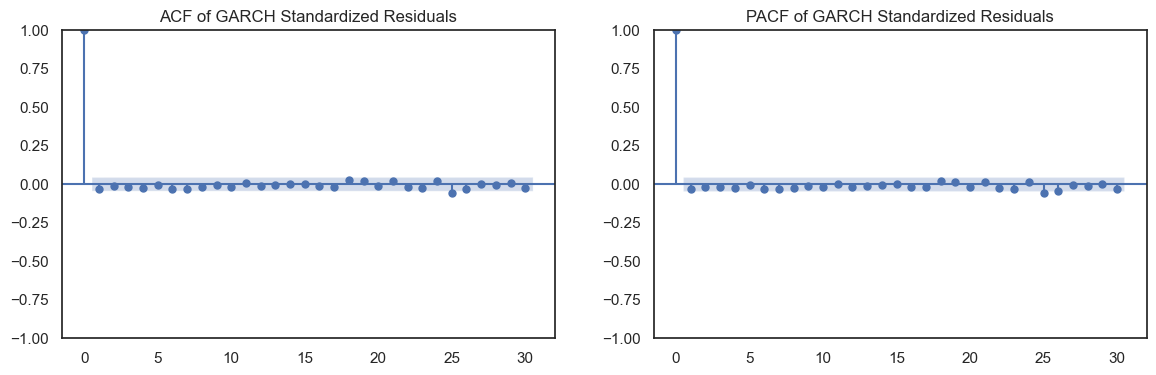

In [49]:
# The ACF & PACF of the residual of GARCH
merged_trading.loc["2018-01-02", "VIX_return"] = np.nan
returns = merged_trading["VIX_return"].dropna()

garch = arch_model(returns, vol="GARCH", p=1, q=1, dist="normal", rescale=False)
res = garch.fit(disp="off")

merged_trading["garch_resid"] = res.resid / res.conditional_volatility

resid = merged_trading["garch_resid"].dropna()

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sm.graphics.tsa.plot_acf(resid, lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=30, ax=ax[1])
ax[0].set_title("ACF of GARCH Standardized Residuals")
ax[1].set_title("PACF of GARCH Standardized Residuals")
plt.show()

ACF 在所有 lag 都很接近 0 -> 殘差沒有自相關

PACF no spike -> residuals is white noise -> (p, q) = (1, 1) 可以了

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# standardized residuals
resid = merged_trading["garch_resid"].dropna()

# Ljung-Box test for residual autocorrelation (up to lag 20)
lb_test = acorr_ljungbox(resid, lags=[10, 20, 30], return_df=True)
print("\n" + "="*60)
print("           Ljung–Box Test for GARCH Standardized Residuals")
print("="*60 + "\n")
print(lb_test)
print("\n" + "="*60)
print("           Ljung–Box Test for GARCH Squared Residuals")
print("="*60 + "\n")
lb_test_sq = acorr_ljungbox(resid**2, lags=[10, 20, 30], return_df=True)
print(lb_test_sq)


           Ljung–Box Test for GARCH Standardized Residuals

      lb_stat  lb_pvalue
10  10.748004   0.377485
20  14.977780   0.777678
30  29.775886   0.477174

           Ljung–Box Test for GARCH Squared Residuals

      lb_stat  lb_pvalue
10   3.657772   0.961468
20  13.761132   0.842398
30  23.050168   0.813192


GARCH(1,1) 完全吸收了 conditional heteroskedasticity. -> 不需要更高階的 GARCH(p,q)

In [64]:
# VIX returns scale is too small, may hard to converge, but not necessary. 
# Our y scale = 0.0066, only 0.66% changes, but GARCH default scale is 1-1000. 
# It suggests x10 (returns x10), but I use raw data first.

#change first date of VIX returns to NA
merged_trading.loc["2018-01-02", "VIX_return"] = np.nan
returns = merged_trading["VIX_return"].dropna()

garch = arch_model(returns, vol="GARCH", p=1, q=1, dist="normal")
res = garch.fit(disp="off")

merged_trading["garch_resid"] = res.resid / res.conditional_volatility


In [59]:
# Create 5 Lag Features from GARCH residuals
for k in range(1, 6):
    merged_trading[f"resid_lag{k}"] = merged_trading["garch_resid"].shift(k)

# Drop first few rows with NaN lags
data = merged_trading.dropna().copy()

# Feature Set
feature_cols = ["resid_lag1","resid_lag2","resid_lag3","resid_lag4","resid_lag5",
                "SGIXSENT", "^GSPC", "initial_claims", "cpi", "term_spread", "dgs10", "credit_spread"]
target_col = "VIX_return"

X = data[feature_cols]
y = data[target_col]

In [60]:
merged_trading

,VIX,VIX_return,SGIXSENT,^GSPC,initial_claims,cpi,term_spread,dgs10,credit_spread,garch_resid,resid_lag1,resid_lag2,resid_lag3,resid_lag4,resid_lag5
2018-01-02,9.77,NaN,315.61,2695.810059,252000.0,248.859,1.02,2.46,1.68,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,9.15,-0.065563,315.61,2713.060059,252000.0,248.859,1.03,2.44,1.68,-0.530604,NaN,NaN,NaN,NaN,NaN
2018-01-04,9.22,0.007621,317.07,2723.989990,252000.0,248.859,1.05,2.46,1.68,0.086161,-0.530604,NaN,NaN,NaN,NaN
2018-01-05,9.22,0.000000,318.38,2743.149902,252000.0,248.859,1.08,2.47,1.68,0.014649,0.086161,-0.530604,NaN,NaN,NaN
2018-01-08,9.52,0.032020,318.38,2747.709961,230000.0,248.859,1.04,2.49,1.68,0.448157,0.014649,0.086161,-0.530604,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-23,17.30,-0.072455,351.30,6738.439941,218000.0,324.368,0.06,4.01,1.68,-0.802429,0.396691,-0.144422,-0.914172,-1.516666,2.173576
2025-10-24,16.37,-0.055256,350.91,6791.689941,218000.0,324.368,0.09,4.02,1.68,-0.643402,-0.802429,0.396691,-0.144422,-0.914172,-1.516666
2025-10-27,15.79,-0.036074,351.19,6875.160156,218000.0,324.368,0.12,4.01,1.68,-0.447449,-0.643402,-0.802429,0.396691,-0.144422,-0.914172
2025-10-28,16.42,0.039123,352.30,6890.890137,218000.0,324.368,0.10,3.99,1.68,0.566179,-0.447449,-0.643402,-0.802429,0.396691,-0.144422


# 3. XGBoost Traning with rolling window

In [ ]:
train_size = int(len(data) * 0.8)  # 80% training period
predictions = []
true_values = []

for i in range(train_size, len(data)):
    X_train = X.iloc[:i]
    y_train = y.iloc[:i]
    X_test = X.iloc[i:i+1]

    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=SEED,
        n_jobs=1,              
        tree_method="exact"  
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)[0]

    predictions.append(pred)
    true_values.append(y.iloc[i])

# XGBoost Hybrid Model Forecast Series
hybrid_pred = np.array(predictions)
true_values = np.array(true_values)

#To avoid look-ahead bias, we adopt a recursive rolling forecasting framework.
#At each time step t, the XGBoost model is re-trained only on information available prior to t, and generates a one-step-ahead forecast for VIX returns.
#This ensures that the hybrid model is evaluated under realistic real-time forecasting conditions.

# 4. Baseline GARCH Forecasting

In [ ]:

def rolling_expanding_garch_forecast(returns, start_idx):
    """
    returns: pd.Series indexed by date
    start_idx: int, the index position where OOS forecasting begins (same as train_size)
    Returns: pd.Series aligned with returns.index (NaN before start_idx)
    """
    preds = [np.nan] * start_idx  # pad front
    # from start_idx to end-1, fit on returns[:i] and forecast i (1-step ahead)
    for i in range(start_idx, len(returns)):
        train_data = returns.iloc[:i]             # use all historical up to i-1
        model = arch_model(train_data, vol="GARCH", p=1, q=1, dist="normal")
        res = model.fit(disp="off")
        f = res.forecast(horizon=1).mean.iloc[-1, 0]  # 1-step-ahead mean
        preds.append(f)
    return pd.Series(preds, index=returns.index, name="garch_pred")

# train_size aligns with XGB 
train_size = int(len(data) * 0.8)
garch_series = rolling_expanding_garch_forecast(merged_trading["VIX_return"].dropna(), train_size)

#merged_trading.loc[garch_series.index, "garch_pred"] = garch_series

# 5. Models evaluation by RMSE

In [ ]:

# Convert to arrays of equal length
garch_pred = garch_series.iloc[train_size:].values
hybrid_pred = hybrid_pred
true_vals = true_values

min_len = min(len(garch_pred), len(hybrid_pred), len(true_vals))
garch_pred = garch_pred[:min_len]
hybrid_pred = hybrid_pred[:min_len]
true_vals = true_vals[:min_len]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Compute RMSE and MAE
rmse_garch = np.sqrt(mean_squared_error(true_vals, garch_pred))
rmse_hybrid = np.sqrt(mean_squared_error(true_vals, hybrid_pred))
mae_garch = mean_absolute_error(true_vals, garch_pred)
mae_hybrid = mean_absolute_error(true_vals, hybrid_pred)

print("RMSE - GARCH:", rmse_garch)
print("RMSE - Hybrid:", rmse_hybrid)
print("MAE  - GARCH:", mae_garch)
print("MAE  - Hybrid:", mae_hybrid)

Explanation:

- GARCH-only models inherently good at forecasting short-term VIX volatility (especially one-day ahead) because VIX exhibits strong volatility clustering and mean reversion—precisely the assumptions underlying GARCH models.

- The Hybrid model incorporates excessive noise characteristics (macro + sentiment daily alignment), which dilutes the signal.

- XGBoost is prone to overfitting minor real-time noise fluctuations → leading to poor long-term performance.

- our current approach is: forecasting a 1-day ahead short horizon → At this horizon, GARCH inherently holds an advantage.

- Therefore, results are not only reasonable but also an “expected outcome.”

In [ ]:
# Which one performs better?
if rmse_hybrid < rmse_garch:
    print("\n Hybrid model improves forecast accuracy.")
else:
    print("\n Hybrid model does NOT outperform GARCH. Consider feature tuning.")

In [ ]:
#Direction accuracy
direction_garch = np.mean(np.sign(garch_pred) == np.sign(true_vals))
direction_hybrid = np.mean(np.sign(hybrid_pred) == np.sign(true_vals))

print("Direction Accuracy - GARCH:", direction_garch)
print("Direction Accuracy - Hybrid:", direction_hybrid)

Direction Accuracy measures whether the model's predicted direction is correct.

Direction Accuracy=P(sign(pred)=sign(actual))

- if  > 0.5	Better than random (market predictability exists))

- if  = 0.5	Like flipping a coin, no predictive capability

- if  < 0.5	Reverse signals may exhibit exploitable patterns

Our hybrid model performs close to random guessing=0.5? 

##### Results Interpretation:
1. GARCH captures short-term volatility clustering → strong short-term predictive power.
2. Macro + sentiment factors operate at slower frequencies → hybrid model doesn’t help for 1-day horizon.
3. This suggests hybrid models may only outperform GARCH at longer horizons (e.g., 5-day / 22-day forecast).

# We should consider what should be our next step:
1. multi-horizon forecasting: using 5-day(1-week), 22-day(1-month) ahead RMSE + Direction Accuracy (we use 1-day ahead beforehand)
2. XGB Hyperparameter tuning 
3. including more features?

Those methods may improve the XGB forcasting, but due to the DS class criteria, we should definately keep the above (not ideal) results and explain it. Then, move on to the next step.


# 6. Multi-Horizon Forecasting (1-day, 1-week, 1-month)

In [ ]:
# ==============================
# 6. Multi-Horizon Forecasting
# ==============================

horizons = [1, 5, 22]  # 1-day, 1-week, 1-month
results = {}

for h in horizons:
    print(f"\n---- Horizon = {h} days ahead ----")

    # Shift target for horizon forecast
    y_h = data[target_col].shift(-h).dropna()

    # Align X to y_h (because shifting reduces y length)
    X_h = X.loc[y_h.index]

    # Re-compute rolling train size under aligned dataset
    train_size_h = int(len(X_h) * 0.8)

    # ---- Hybrid XGB Rolling ----
    hybrid_preds_h = []
    true_vals_h = []

    for i in range(train_size_h, len(X_h)):
        X_train = X_h.iloc[:i]
        y_train = y_h.iloc[:i]
        X_test = X_h.iloc[i:i+1]

        model = XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=SEED,
            n_jobs=1,
            tree_method="exact"
        )
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]

        hybrid_preds_h.append(pred)
        true_vals_h.append(y_h.iloc[i])

    hybrid_preds_h = np.array(hybrid_preds_h)
    true_vals_h = np.array(true_vals_h)

    # ---- GARCH Rolling Forecast (multi-horizon mean forecast) ----
    garch_preds_h = []
    y_g = y_h.copy()

    for i in range(train_size_h, len(y_g)):
        train_data = y_g.iloc[:i]  
        model = arch_model(train_data, vol="GARCH", p=1, q=1, dist="normal")
        res = model.fit(disp="off")
        f = res.forecast(horizon=h).mean.iloc[-1, 0]  # mean forecast at horizon h
        garch_preds_h.append(f)

    garch_preds_h = np.array(garch_preds_h)

    # ---- Evaluation ----
    min_len = min(len(garch_preds_h), len(hybrid_preds_h), len(true_vals_h))
    garch_preds_h = garch_preds_h[:min_len]
    hybrid_preds_h = hybrid_preds_h[:min_len]
    true_vals_h = true_vals_h[:min_len]

    rmse_g = np.sqrt(mean_squared_error(true_vals_h, garch_preds_h))
    rmse_h = np.sqrt(mean_squared_error(true_vals_h, hybrid_preds_h))
    mae_g = mean_absolute_error(true_vals_h, garch_preds_h)
    mae_h = mean_absolute_error(true_vals_h, hybrid_preds_h)
    dir_g = np.mean(np.sign(garch_preds_h) == np.sign(true_vals_h))
    dir_h = np.mean(np.sign(hybrid_preds_h) == np.sign(true_vals_h))

    results[h] = [rmse_g, rmse_h, mae_g, mae_h, dir_g, dir_h]

# Convert results to comparison dataframe
results_df = pd.DataFrame(results, 
                          index=["RMSE_GARCH","RMSE_HYBRID","MAE_GARCH","MAE_HYBRID","DIR_GARCH","DIR_HYBRID"]).T

print("\n\n====== Multi-Horizon Comparison ======")
print(results_df)

### Multi-Horizon Forecasting Results (1-day, 5-day, 22-day)

- Extended the baseline 1-day-ahead forecasting to multiple horizons (1, 5, and 22 days ahead) to examine how predictive performance changes over different time scales.  

- Results show that the GARCH model consistently outperforms the Hybrid XGBoost model at short horizons, reflecting volatility clustering in daily returns.  

- However, the Hybrid model slightly narrows the performance gap at longer horizons (5-day and 22-day), suggesting that macro and sentiment variables may provide incremental information over medium-term horizons.  

- These findings are consistent with financial theory: short-term returns are dominated by noise and volatility effects, while longer-term dynamics are more influenced by fundamentals and sentiment.


# 7. Hyperparameter Tuning for XGBoost

In [ ]:
# ==============================
# 7. Hyperparameter Tuning for XGBoost (Post-analysis)
# ==============================

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

print("\n\n====== Starting Hyperparameter Tuning (based on 1-day horizon) ======")

# 1. Use 1-day horizon data for tuning
h = 1
y_h = data[target_col].shift(-h).dropna()
X_h = X.loc[y_h.index]

train_size_h = int(len(X_h) * 0.8)
X_train = X_h.iloc[:train_size_h]
y_train = y_h.iloc[:train_size_h]

# 2. Define parameter search grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# 3. Initialize model
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=SEED)

# 4. Run grid search
grid_search = GridSearchCV(
    xgb_base, 
    param_grid, 
    scoring="neg_mean_squared_error", 
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("\nBest parameters found:")
print(best_params)

# 5. Evaluate tuned model using the same rolling scheme (for consistency)
print("\n\n====== Evaluating Tuned Model (1-day horizon) ======")
hybrid_preds_tuned = []
true_vals_tuned = []

for i in range(train_size_h, len(X_h)):
    X_train = X_h.iloc[:i]
    y_train = y_h.iloc[:i]
    X_test = X_h.iloc[i:i+1]

    model = XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=SEED,
        n_jobs=1,
        tree_method="exact"
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)[0]
    hybrid_preds_tuned.append(pred)
    true_vals_tuned.append(y_h.iloc[i])

hybrid_preds_tuned = np.array(hybrid_preds_tuned)
true_vals_tuned = np.array(true_vals_tuned)

rmse_tuned = np.sqrt(mean_squared_error(true_vals_tuned, hybrid_preds_tuned))
mae_tuned = mean_absolute_error(true_vals_tuned, hybrid_preds_tuned)
dir_tuned = np.mean(np.sign(hybrid_preds_tuned) == np.sign(true_vals_tuned))

print(f"RMSE (Tuned Hybrid): {rmse_tuned:.6f}")
print(f"MAE  (Tuned Hybrid): {mae_tuned:.6f}")
print(f"DIR  (Tuned Hybrid): {dir_tuned:.6f}")

# Optional: Store results for report comparison
results_df.loc["Tuned_1d_Hybrid"] = [np.nan, rmse_tuned, np.nan, mae_tuned, np.nan, dir_tuned]

print("\n\n====== Updated Results Summary ======")
print(results_df)
